In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random as rnd
from scipy import special
from scipy.optimize import curve_fit
import json
from scipy.stats.distributions import zeta

ImportError: cannot import name 'zeta' from 'scipy.stats.distributions' (/Users/matthewbone/Documents/Coding/VSCode/macro-model-eda/edaEnv/lib/python3.11/site-packages/scipy/stats/distributions.py)

In [4]:
comps_df = pd.read_csv('raw_data/UKCompSizes.csv', sep='\t', header=0)
comps_df.index = list(comps_df['Unnamed: 0'])
del comps_df['Unnamed: 0']
del comps_df['Total']
comps_df

,0-4,5-9,10-19,20-49,50-99,100-249,250
"Agriculture, forestry & fishing","18,615","3,775","1,625",910,255,120,70
Production,"84,745","22,530","15,735","12,715","5,350","3,240","1,525"
Construction,"258,305","30,635","13,875","6,335","1,945",890,220
Motor trades,"43,660","12,860","5,965","4,000","1,075",310,35
Wholesale,"69,495","20,075","13,005","7,620","2,230",945,365
Retail,"139,145","52,260","31,845","16,795","3,445","2,285","1,170"
Transport & Storage (inc. postal),"79,035","11,130","6,835","5,265","2,395","1,460",735
Accommodation & food services,"77,535","38,850","29,850","20,680","3,890","1,575",245
Information & communication,"165,550","12,665","8,080","5,600","2,125","1,025",580
Finance & insurance,"38,750","8,110","4,540","2,525",970,675,660


In [5]:
def industry_dist(df, industry):

    employees = []
    counts = []
    for idx, count in enumerate(df.loc[industry, :]):

        emp_range = [int(n) for n in df.columns[idx].split('-')]
        
        counts.append(int(count.replace(',', '')))
        employees.append(np.mean(emp_range))

    return np.array(counts), np.array(employees)

In [6]:
industry_dists = {}
for i in comps_df.index:
    industry_dists[i] = industry_dist(comps_df, i)

zeta / zipf distribution pdf: https://www.statisticshowto.com/zeta-distribution-zipf/

$$ f(x)=\frac{1}{x^\alpha \sum_{i=1}^{n} (1/i)^\alpha} $$

computed with analytic continuation so that it can be computed for $\alpha<1$

In [131]:
special.zetac(2)

0.6449340668482264

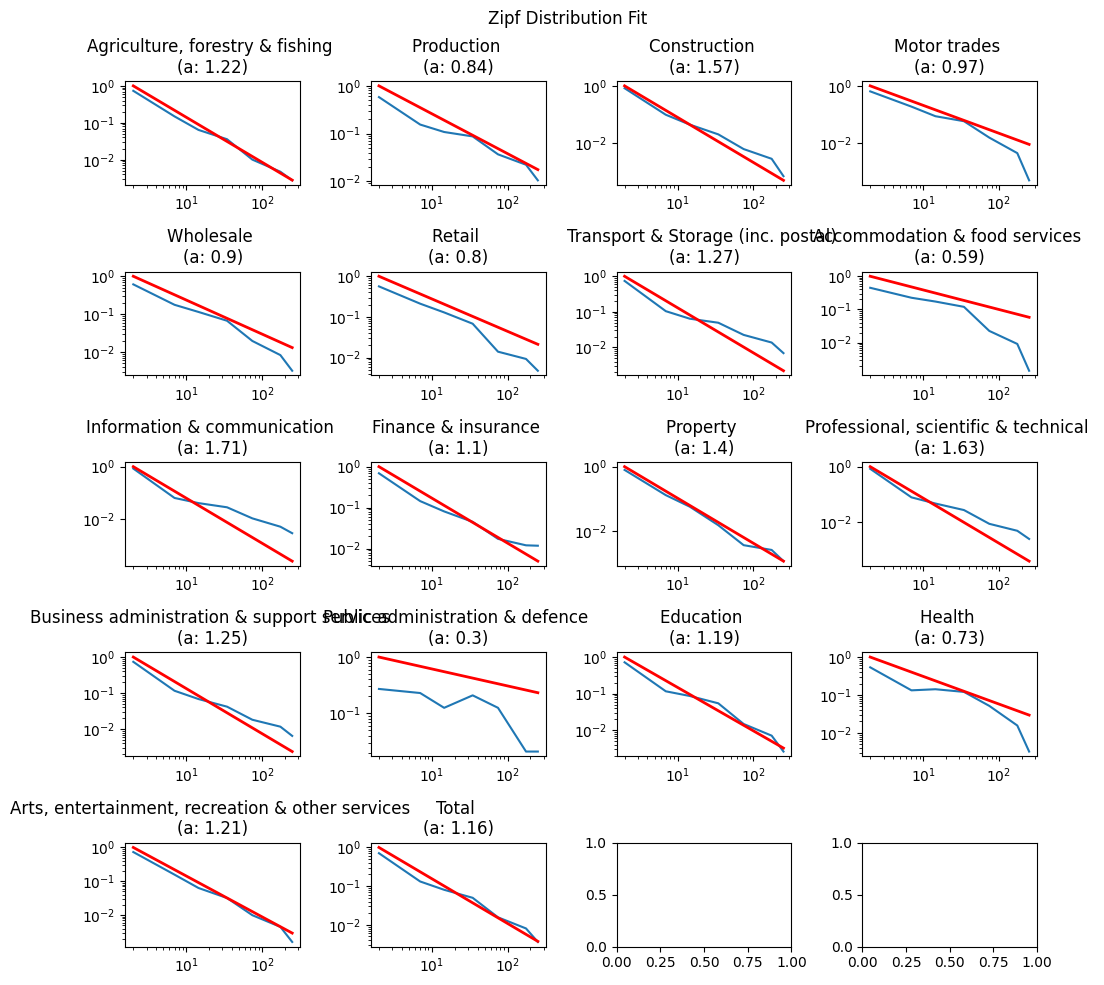

In [105]:

fig, axes = plt.subplots(5,4)
fig.set_figheight(10)
fig.set_figwidth(10)

def f(x, a):
    z = 1 / (x**(a) * special.zetac(a))
    return z / sum(z)

params = {}

for idx, ind in enumerate(comps_df.index):

    normalized_employees = industry_dists[ind][1]
    normalized_density = industry_dists[ind][0] / sum(industry_dists[ind][0])

    axes[int(idx / 4), idx % 4].plot(normalized_employees, normalized_density)
    result = curve_fit(f, normalized_employees, normalized_density, p0=[1.16])
    
    a = result[0][0]
    params[ind] = a
    x = normalized_employees
    z = x**(-a) / special.zetac(a)
    y = z / sum(z)

    axes[int(idx / 4), idx % 4].plot(x, y / max(y), linewidth=2, color='r')
    axes[int(idx / 4), idx % 4].set_title(f"{ind} \n(a: {round(a,2)})")
    axes[int(idx / 4), idx % 4].set_yscale('log')
    axes[int(idx / 4), idx % 4].set_xscale('log')

fig.suptitle('Zipf Distribution Fit')
fig.tight_layout()

In [111]:
a = 1.22
range = np.arange(1,1000)
probs = 1 / (range**(a) * special.zetac(a))
sample = np.random.choice(range, p=probs / sum(probs), size=100000)

pareto_sample = np.random.pareto(3, 100000)

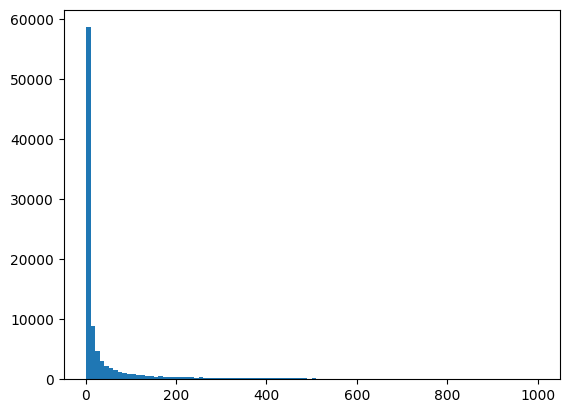

In [112]:
plt.hist(sample, bins=100)
plt.show()

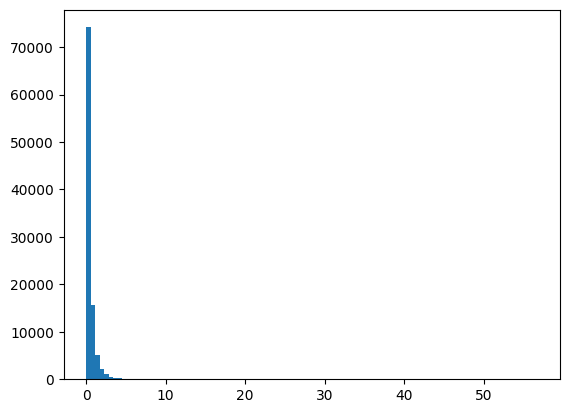

In [113]:
plt.hist(pareto_sample, bins=100)
plt.show()

this is using the map provided in the datasheet here: https://www.ons.gov.uk/businessindustryandtrade/business/activitysizeandlocation/datasets/ukbusinessactivitysizeandlocation

In [10]:
SIC_MAP = {}
SIC_MAP['A'] = params['Agriculture, forestry & fishing']
SIC_MAP['B'] = params['Production']
SIC_MAP['C'] = params['Production']
SIC_MAP['D'] = params['Production']
SIC_MAP['E'] = params['Production']
SIC_MAP['F'] = params['Construction']
SIC_MAP['G'] = params['Wholesale']
SIC_MAP['H'] = params['Transport & Storage (inc. postal)']
SIC_MAP['I'] = params['Accommodation & food services']
SIC_MAP['J'] = params['Information & communication']
SIC_MAP['K'] = params['Finance & insurance']
SIC_MAP['L'] = params['Property']
SIC_MAP['M'] = params['Professional, scientific & technical']
SIC_MAP['N'] = params['Business administration & support services']
SIC_MAP['O'] = params['Public administration & defence']
SIC_MAP['P'] = params['Education']
SIC_MAP['Q'] = params['Health']
SIC_MAP['R'] = params['Arts, entertainment, recreation & other services']
SIC_MAP['S'] = params['Arts, entertainment, recreation & other services']
SIC_MAP['T'] = params['Arts, entertainment, recreation & other services']
SIC_MAP['U'] = params['Arts, entertainment, recreation & other services']

In [11]:
with open('employmentAlphas.json', 'w') as f:
    f.write(json.dumps(SIC_MAP))